<a href="https://colab.research.google.com/github/JoDeMiro/TimeSeriesLearn/blob/main/18_TSLearn_Shapelet_locations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


# Aligning discovered shapelets with timeseries

This example illustrates the use of the "Learning Shapelets" method in order
to learn a collection of shapelets that linearly separates the timeseries.
In this example, we will extract a single shapelet in order to distinguish
between two classes of the "Trace" dataset. Afterwards, we show how our time
series can be transformed to distances by aligning the shapelets along each of
the time series. This alignment is performed by shifting the smaller shapelet
across the longer time series and taking the minimal pointwise distance.

More information on the method can be found at:
http://fs.ismll.de/publicspace/LearningShapelets/.


In [2]:
!pip install -q tslearn

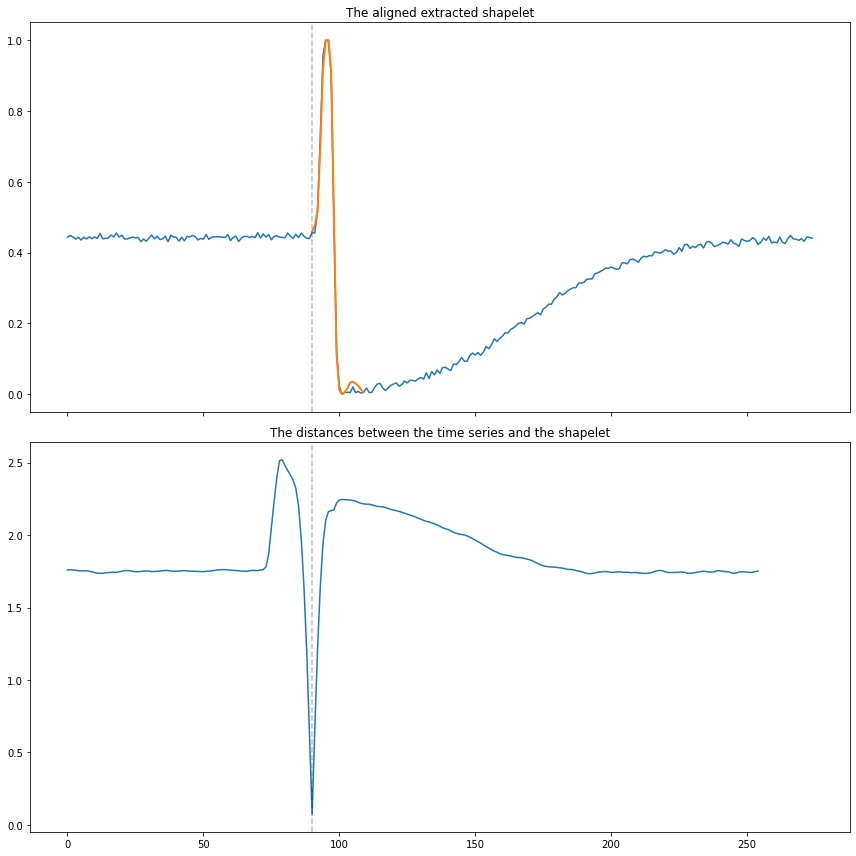

In [4]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set a seed to ensure determinism
numpy.random.seed(42)

# Load the Trace dataset
X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")

# Filter out classes 2 and 4
mask = numpy.isin(y_train, [1, 3])
X_train = X_train[mask]
y_train = y_train[mask]

# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {20: 1}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=Adam(learning_rate=0.01),
                            max_iter=250,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train, y_train)

# Get the number of extracted shapelets, the (minimal) distances from
# each of the timeseries to each of the shapelets, and the corresponding
# locations (index) where the minimal distance was found
n_shapelets = sum(shapelet_sizes.values())
distances = shp_clf.transform(X_train)
predicted_locations = shp_clf.locate(X_train)

f, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.
test_ts_id = numpy.argmin(numpy.sum(distances, axis=1))
shap = shp_clf.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, 0]
ax[0].plot(X_train[test_ts_id].ravel())
ax[0].plot(numpy.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances = []
time_series = X_train[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances.append(numpy.linalg.norm(time_series[i:i+len(shap)] - shap))
ax[1].plot(distances)
ax[1].axvline(numpy.argmin(distances), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()